In [1]:
# Author: Davide Aloi - PhD student - University of Birmingham
# Description: the script loads the results from wp_all_8_current_density_metrics, which are 3
# .csv files, and correlates current density metrics with DCM values.
# The analysis method used is Canonical correlation analysis (CCA)
# Add details on CCA
## WORKING ON THIS AT THE MOMENT (25012022)
# Imports
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
## Parameters and variables: 
results_folder = 'D:\\roast-chapter3\\wp_all_results\\' # Folder with results (current density)
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' # Project folder
dcm_results_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\all_dcm_results\\' # Folder with dcm results

# Datasets names and subjects lists
#db_names = ['wp2a', 'wp1b'] # waiting for wp1a results from Davinia
db_names = ['wp2a']

-------- CCA analysis for dataset wp2a ---------
Current density metrics
   m1_medians    m1_max  th_medians    th_max  cb_medians    cb_max
0    1.064099 -0.222754   -0.387600  2.239864   -0.733822 -0.615235
1    1.202965  1.111482   -0.967031 -0.837454   -0.063144 -0.028971
2   -0.107853  1.544385   -0.503373  0.143153   -0.851981 -1.144642
3   -0.665023 -1.268581   -0.250689 -0.461470    0.746472 -1.155159
4    0.777813  0.006170    1.643100 -0.504230    2.059322  0.327670

DCM values
       m1m1      thth      m1th      thm1
0  0.300931  1.085120 -1.125615 -0.815612
1 -1.533606  0.598047  0.172432 -0.076831
2 -2.011669 -1.517923 -0.709467  0.424610
3  1.769832  0.171052 -0.640999 -0.924352
4 -0.010210  0.366904 -0.165926 -0.092548

Correlations between CV pairs
r1=0.683, p1=0.00046
r2=0.566, p2=0.00607


Correlations between first current density variate and DCM measures
m1m1: r=0.635, p=0.0015
thth: r=0.52, p=0.01304
m1th: r=0.173, p=0.44042
thm1: r=-0.246, p=0.26965

Correlations

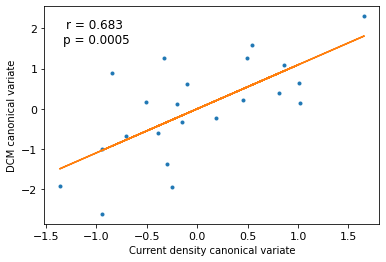

In [3]:
from sklearn.cross_decomposition import CCA

for db_id, db in enumerate(db_names):
    print('-------- CCA analysis for dataset ' + db + ' ---------')

    # Loading DCM results (nb: the unthresholded ones, for the correlation analysis)
    DCM = np.load(os.path.join(dcm_results_folder, db + '_dcm_unthresholded.npy'))
    DCM_sham = np.load(os.path.join(dcm_results_folder, db + '_dcm_sham_unthresholded.npy'))

    # Loading current density results
    cd_metrics = pd.read_csv(os.path.join(results_folder, db +'_current_density_results.csv'))
    cd_metrics.drop('Unnamed: 0', axis = 1, inplace = True) # Dropping participants' id

    # Simple R correlation (example)
    #x = cd_metrics['m1_medians'].values # Medians current density in M1
    #y = DCM[:, 0, 0] # NB: DCM index related to m1 <-> m1 (of all subjects) = [0,0]
    #r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
    #print ('R: ' + str(round(r,3)) + ', p: ' +  str(round(p,3)))

    # Extracting DCM values I am interested in (m1<->m1, th<->th, m1->th, th->m1)
    dcm_df = pd.DataFrame(zip(DCM[:,0,0], DCM[:,1,1], DCM[:,1,0], DCM[:,0,1]),
                                columns = ['m1m1', 'thth', 'm1th',
                                'thm1'])

    # We first standardise our variables by subtracting with mean and dividing by standard deviation
    cd_df_s = (cd_metrics-cd_metrics.mean())/(cd_metrics.std())
    dcm_df_s = (dcm_df-dcm_df.mean())/(dcm_df.std())

    print('Current density metrics')
    print(cd_df_s.head())
    print('\nDCM values')
    print(dcm_df_s.head())

    ''' Damian: Basically your CCA analysis will give you pairs of canonical variates (one of
    each pair that describes the current measures, and one that describes the DCM). For each
    significant pair, you then correlate the CV from one side with each of the individual
    measures from the other side.
    This will basically tell you that e.g., Current density overall is most strongly related to
    DCM connectivity in pathways X and Y, and that DCM connectivity overall is most strongly
    related to current density in region A and B. '''

    # CCA using scikit-learn (X = current measures, Y = DCM measures)
    cca = CCA(n_components = 2, max_iter = 2000)
    cca.fit(cd_df_s, dcm_df_s)
    X_c, Y_c = cca.transform(cd_df_s, dcm_df_s)    

    # Dataframe containing Canonical Variates (CV)
    cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                           "CCY_1":Y_c[:, 0],
                           "CCX_2":X_c[:, 1],
                           "CCY_2":Y_c[:, 1]})

    # Correlation between pairs of canonical variates 
    r1,p1  = scipy.stats.pearsonr(X_c[:, 0], Y_c[:, 0])
    r2,p2  = scipy.stats.pearsonr(X_c[:, 1], Y_c[:, 1])

    print('\nCorrelations between CV pairs')
    print('r1=' + str(round(r1,3)) + ', p1=' +  str(round(p1,5)))
    print('r2=' + str(round(r2,3)) + ', p2=' +  str(round(p2,5)))
    print('\n')

    ## Ploting correlation between 1st pair of CVs
    import matplotlib.pyplot as plt
    from numpy.polynomial.polynomial import polyfit
    
    x, y = X_c[:,0], Y_c[:,0]
    b, m = polyfit(x, y, 1)

    plt.rcParams['figure.facecolor'] = 'white'
    plt.plot(x, y, '.')
    plt.xlabel('Current density canonical variate')
    plt.ylabel('DCM canonical variate')
    plt.plot(x, b + m * x, '-')
    plt.tick_params(axis='both', which='major', labelsize=11)
    plt.text(-1, 1.9, 'r = ' + str(round(r1, 4)) + ' \np = ' + str(round(p1,4)), horizontalalignment='center',
                        verticalalignment='center', fontsize = 12)

    # Correlation of DCM values with first current density CV (X_c[:,0])    
    r_list_dcm = [] # list of R
    p_list_dcm = [] # list of p values

    print('Correlations between first current density variate and DCM measures')
    for DCM_measure in dcm_df_s:
        r, p = scipy.stats.pearsonr(X_c[:, 0], dcm_df_s[DCM_measure])
        print(DCM_measure +': r=' + str(round(r,3)) + ', p=' +  str(round(p,5)))
        r_list_dcm.append(r)
        p_list_dcm.append(p)


    # Correlation of Current density values with first DCM covariate (Y_c[:,0])
    r_list_cd = [] # list of R
    p_list_cd = [] # list of p values

    print('\nCorrelations between first DCM variate and current density measures')
    for CD_measure in cd_df_s:
        r, p = scipy.stats.pearsonr(Y_c[:, 0], cd_df_s[CD_measure])
        print(CD_measure +': r=' + str(round(r,3)) + ', p=' +  str(round(p,5)))
        r_list_cd.append(r)
        p_list_cd.append(p)

  measure         r         p  rank      sig
0    m1m1  0.635039  0.001497     3      sig
1    thth  0.520365  0.013039     2      sig
2    thm1 -0.246067  0.269651     1  not-sig
3    m1th  0.173347  0.440423     0  not-sig


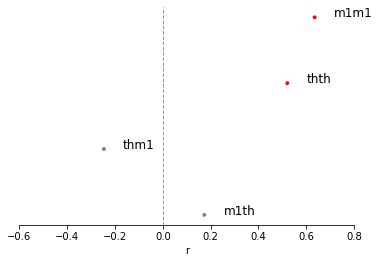

In [7]:
import seaborn as sns

df_cor = pd.DataFrame({"measure": dcm_df_s.columns,
                            "r": r_list_dcm,
                           "p":p_list_dcm})
                     
df_cor = df_cor.sort_values(by=['p']).reset_index(drop=True)
df_cor['rank'] = np.flip(df_cor.index.values)
df_cor['sig'] =  np.where(df_cor['p']<0.05, 'sig', 'not-sig')
print(df_cor)

ax = sns.scatterplot('r', # Horizontal axis
           'rank', # Vertical axis
           data = df_cor, # Data source
           size = 10,
           hue = 'sig',
           palette = ['red','gray'],
           legend = False,
           
           ) 

ax.set_xticks(np.arange(-1,1,0.2))

plt.xlim(-0.6,0.8)
sns.despine(left=True)
plt.gca().axes.get_yaxis().set_visible(False)
plt.axvline(x=0, color='k', linestyle='--', alpha = 0.4, linewidth = 1)

# Plotting measures' names
for i, measure in enumerate (df_cor.measure):
    plt.text(df_cor.r[i]+0.08, df_cor['rank'].values[i]+0.01, measure, fontdict={'size': 12})

      measure         r         p  rank      sig
0  th_medians  0.485694  0.021930     5      sig
1      m1_max -0.264977  0.233357     4  not-sig
2  m1_medians  0.060458  0.789265     3  not-sig
3  cb_medians -0.038628  0.864484     2  not-sig
4      th_max -0.014316  0.949581     1  not-sig
5      cb_max  0.010545  0.962851     0  not-sig


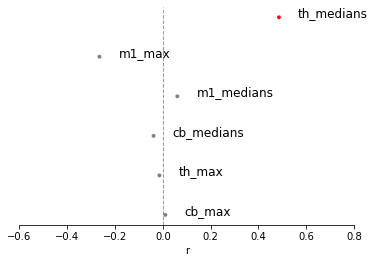

In [9]:
df_cor = pd.DataFrame({"measure": cd_df_s.columns,
                            "r": r_list_cd,
                           "p":p_list_cd})
                     
df_cor = df_cor.sort_values(by=['p']).reset_index(drop=True)

df_cor['rank'] = np.flip(df_cor.index.values)

df_cor['sig'] =  np.where(df_cor['p']<0.05, 'sig', 'not-sig')

print(df_cor)

ax = sns.scatterplot('r', # Horizontal axis
           'rank', # Vertical axis
           data = df_cor, # Data source
           size = 10,
           hue = 'sig',
           palette = ['red','gray'],
           legend = False,) 

ax.set_xticks(np.arange(-1,1,0.2))

plt.xlim(-0.6,0.8)
sns.despine(left=True)
plt.gca().axes.get_yaxis().set_visible(False)
plt.axvline(x=0, color='k', linestyle='--', alpha = 0.4, linewidth = 1)

# Plotting measures' names
for i, measure in enumerate (df_cor.measure):
    plt.text(df_cor.r[i]+0.08, df_cor['rank'].values[i]+0.01, measure, fontdict={'size': 12})